In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Define input training data and parameter

In [2]:
input_signal_num = 100000 # number of training data
input_data = 5*np.random.randn(input_signal_num, 1) # generate # of gaussian dist input
mean_w = 0.0 # mean of noise
std_w = 1.0 # std of noise
k = 0.2

Setting is the same as table 1 of paper (Learning Approaches to the Witsenhausen Counterexample From a
View of Potential Games)

# Define encoder and decoder (seperate scope, like: GAN)

In [3]:
# input x
x = tf.placeholder(tf.float32, [None, 1])
tmp_c = tf.placeholder(tf.float32, [None, 1])
noise = tf.placeholder(tf.float32, [None, 1])
# first neural network (encoder)
with tf.variable_scope("encoder") as scope1:
    l1 = tf.layers.dense(inputs = x, units = 512, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1),name = 'e1')
        
    l2 = tf.layers.dense(inputs = l1, units = 256, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1),name = 'e2')

    l3_a = tf.layers.dense(inputs = l2, units = 128, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1),name = 'e3')

    l3_ab = tf.layers.dense(inputs = l3_a, units = 64, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1), name = 'e4')

    # output of first neural network
    u1 = tf.layers.dense(inputs = l3_ab, units = 1,  
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), name = 'u1')


# gaussian noise
w = tf.random_normal([input_signal_num, 1], mean=mean_w, stddev=std_w, dtype=tf.float32, seed=None)

# add u1 with gaussian noise
y = tf.add(tf.multiply(u1, tmp_c), noise)


# second neural network (decoder)
with tf.variable_scope("decoder") as scope2:
    l3 = tf.layers.dense(inputs = y, units = 512, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1), name = 'd1')
        
    l4 = tf.layers.dense(inputs = l3, units = 256, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1), name = 'd2')

    l5_a = tf.layers.dense(inputs = l4, units = 128, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1), name = 'd3')

    l5_ab = tf.layers.dense(inputs = l5_a, units = 64, activation = tf.nn.relu, 
                    kernel_initializer = tf.random_normal_initializer(0.,.1), 
                    bias_initializer = tf.constant_initializer(0.1), name = 'd4')

    # output of second neural network
    u2 = tf.layers.dense(inputs = l5_ab, units = 1,  
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), name = 'u2')

In [4]:
encoder_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'encoder')
encoder_var

[<tf.Variable 'encoder/e1/kernel:0' shape=(1, 512) dtype=float32_ref>,
 <tf.Variable 'encoder/e1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'encoder/e2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'encoder/e2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'encoder/e3/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'encoder/e3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'encoder/e4/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'encoder/e4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'encoder/u1/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'encoder/u1/bias:0' shape=(1,) dtype=float32_ref>]

In [5]:
decoder_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'decoder')
decoder_var

[<tf.Variable 'decoder/d1/kernel:0' shape=(1, 512) dtype=float32_ref>,
 <tf.Variable 'decoder/d1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'decoder/d2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'decoder/d2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'decoder/d3/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'decoder/d3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'decoder/d4/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'decoder/d4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'decoder/u2/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'decoder/u2/bias:0' shape=(1,) dtype=float32_ref>]

# Define loss function

In [6]:
loss = k * tf.reduce_mean(tf.square(u1)) + tf.reduce_mean(tf.square(u2 - x)) # k(u1-x)^2+(u2-u1)^2
optimizer = tf.train.AdamOptimizer(0.001)
train_opt1 = optimizer.minimize(loss, var_list=encoder_var)
train_opt2 = optimizer.minimize(loss, var_list=decoder_var)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
x_axis = np.array([np.linspace(-20, 20, num=input_signal_num).tolist()]).T

# Before optimization with loss function

In [9]:
y_axis = sess.run(u1, feed_dict = {x:x_axis})

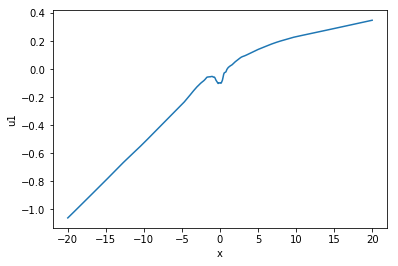

In [10]:
plt.plot(x_axis[:,0],y_axis[:,0])
plt.xlabel('x')
plt.ylabel('u1')
plt.show()

# Optimization

optimize encoder
current loss (every 30 iteration): 24.6433


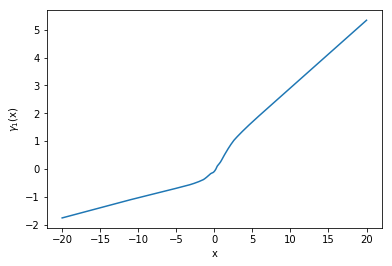

optimize decoder
current loss (every 30 iteration): 12.0992


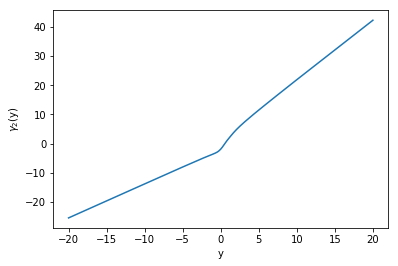

optimize encoder
current loss (every 30 iteration): 6.72276


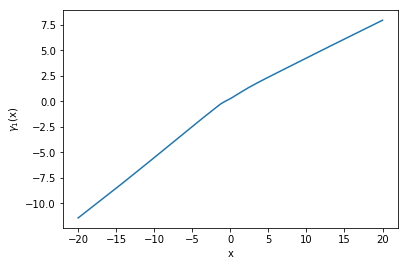

optimize decoder
current loss (every 30 iteration): 5.06921


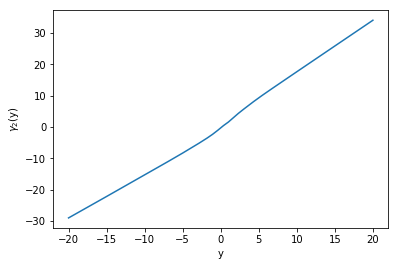

optimize encoder
current loss (every 30 iteration): 4.74875


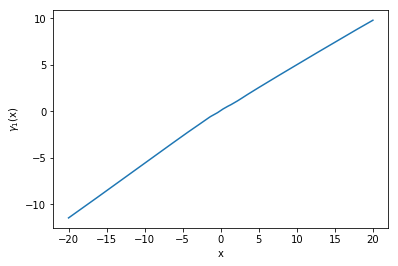

optimize decoder
current loss (every 30 iteration): 4.58808


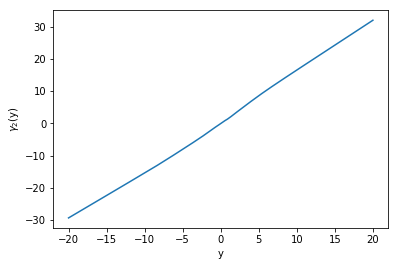

optimize encoder
current loss (every 30 iteration): 4.44116


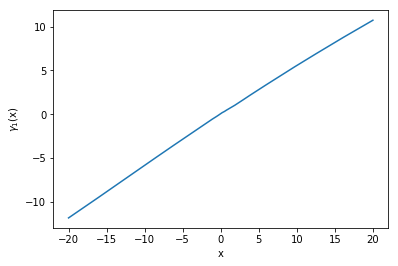

optimize decoder
current loss (every 30 iteration): 4.39959


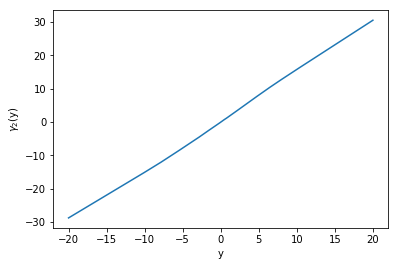

optimize encoder
current loss (every 30 iteration): 4.36766


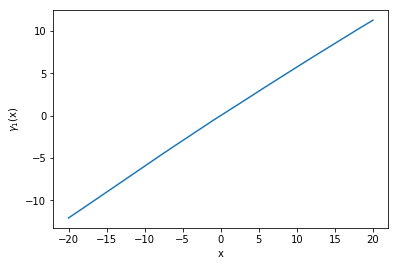

optimize decoder
current loss (every 30 iteration): 4.31934


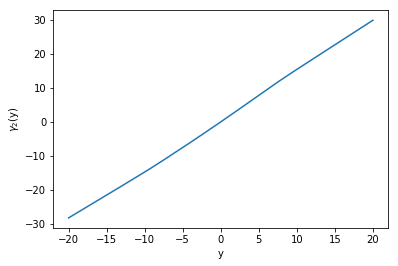

optimize encoder
current loss (every 30 iteration): 4.3187


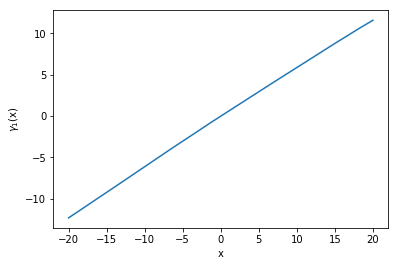

optimize decoder
current loss (every 30 iteration): 4.29444


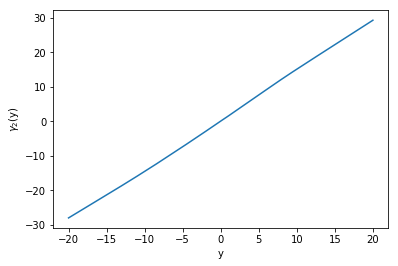

optimize encoder
current loss (every 30 iteration): 4.29156


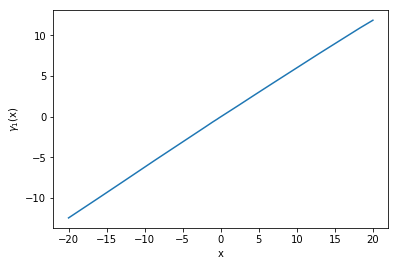

optimize decoder
current loss (every 30 iteration): 4.29696


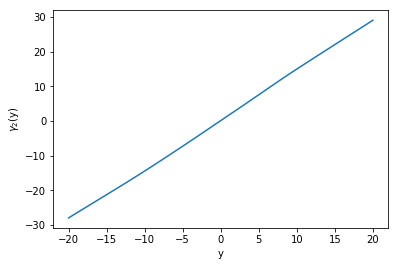

optimize encoder
current loss (every 30 iteration): 4.29565


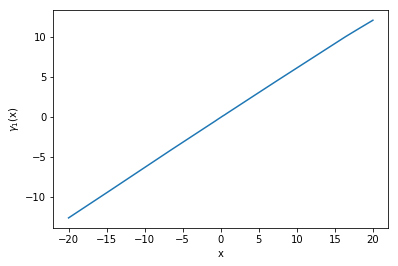

optimize decoder
current loss (every 30 iteration): 4.28028


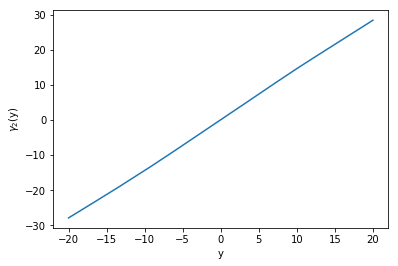

optimize encoder
current loss (every 30 iteration): 4.28148


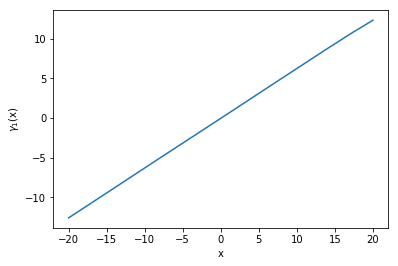

optimize decoder
current loss (every 30 iteration): 4.26598


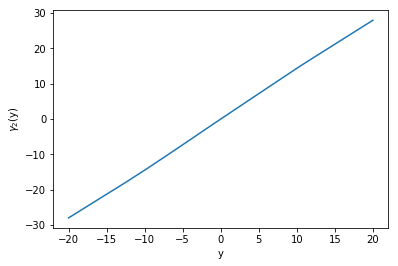

optimize encoder
current loss (every 30 iteration): 4.27591


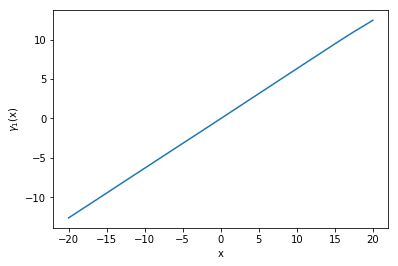

optimize decoder
current loss (every 30 iteration): 4.27505


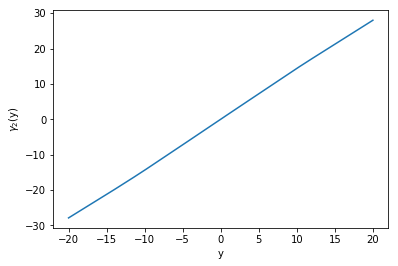

In [11]:
for index in range(10): # total 40
    # optimize encoder
    print('optimize encoder')
    for i in range(30):
        input_data = 5*np.random.randn(input_signal_num, 1) # generate # of gaussian dist input
        feed_dict2 = {x:input_data, tmp_c : np.array([[1]]), noise: np.random.randn(input_signal_num, 1)}
        sess.run(train_opt1, feed_dict2)
        if i % 30 == 29:
            print('current loss (every 30 iteration):',sess.run(loss,feed_dict2))
            y_axis = sess.run(u1, feed_dict = {x:x_axis, tmp_c : np.array([[0]]), noise: x_axis})
            plt.plot(x_axis[:,0],y_axis[:,0])
            plt.xlabel('x')
            plt.ylabel('$\gamma_1$(x)')
            plt.show()
        
    # optimize decoder
    print('optimize decoder')
    for i in range(30):
        input_data = 5*np.random.randn(input_signal_num, 1) # generate # of gaussian dist input
        feed_dict2 = {x:input_data ,tmp_c : np.array([[1]]), noise: np.random.randn(input_signal_num, 1)}
        sess.run(train_opt2, feed_dict2)
        if i % 30 == 29:
            print('current loss (every 30 iteration):',sess.run(loss,feed_dict2))
            y_axis = sess.run(u2, feed_dict = {x:x_axis,tmp_c : np.array([[0]]), noise: x_axis})
            plt.plot(x_axis[:,0],y_axis[:,0])
            plt.xlabel('y')
            plt.ylabel('$\gamma_2$(y)')
            plt.show()

# After optimization with loss

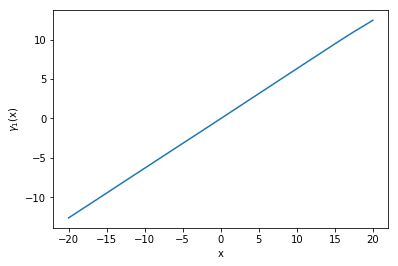

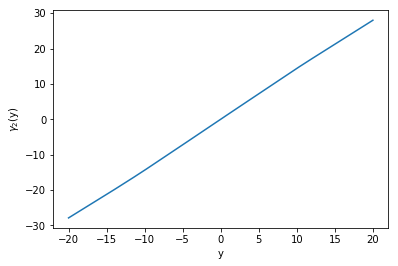

In [12]:
y_axis = sess.run(u1, feed_dict = {x:x_axis})
plt.plot(x_axis[:,0],y_axis[:,0])
plt.xlabel('x')
plt.ylabel('$\gamma_1$(x)')
plt.show()
y_axis = sess.run(u2, feed_dict = {x:x_axis,tmp_c : np.array([[0]]), noise: x_axis})
plt.plot(x_axis[:,0],y_axis[:,0])
plt.xlabel('y')
plt.ylabel('$\gamma_2$(y)')
plt.show()